In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import equinox as eqx
from jax import random
from jax.random import PRNGKey, split
from jax import jit, grad
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

from dysts.flows import Lorenz, Rossler


In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='icefire', font='serif',
            font_scale=1, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
# jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')

In [ ]:
# | export

class Model(eqx.Module):
    layers: list

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.tanh(layer(x))
        return self.layers[-1](x)

In [ ]:
# | export

def MLP(layer_sizes, key):
    keys = split(key, len(layer_sizes) - 1)
    layers = [
        eqx.nn.Linear(in_size, out_size, key=k)
        for in_size, out_size, k in zip(layer_sizes[:-1], layer_sizes[1:], keys)
    ]
    return Model(layers)

In [ ]:
# | export

@eqx.filter_value_and_grad()
def compute_loss(params, x, y):
    preds = jax.vmap(params)(x)
    mse = jnp.mean((preds - y) ** 2)
    nrmse = jnp.sqrt(mse) / jnp.std(y)
    return mse

In [ ]:
# | export

@eqx.filter_jit
def train_step(params, x, y, opt_state, opt_update):
    loss, grads = compute_loss(params, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    return loss, params, opt_state

In [ ]:
# Compute the gradient norm
def grad_norm(grads):
    return jnp.sqrt(sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(grads)))


In [ ]:
def generate_data(num_samples):
    model = Lorenz()
    lorenz = model.make_trajectory(num_samples, resample=True)
    x = lorenz[:, 0]
    y = lorenz[:, 1]
    z = lorenz[:, 2]
    # inp = jnp.stack([y, z], axis=1)
    # inp = jnp.arange(num_samples).reshape(-1,1)
    # inp = y.reshape(-1,1)
    inp = jnp.stack([z, y], axis=1)
    out = x.reshape(-1,1)
    return inp, out

In [ ]:
# def generate_data(num_samples):

#     x = jnp.linspace(0, 2 * jnp.pi, num_samples)
#     y_sin = 0.5 * jnp.sin(x)
#     y_cos = 0.5 * jnp.cos(x)
#     # return x.reshape(-1,1), y_sin.reshape(-1,1)
#     # return y_sin.reshape(-1, 1), y_cos.reshape(-1, 1)
#     return jnp.stack([y_cos, y_cos], axis=1), y_sin.reshape(-1, 1)

In [ ]:
inp, out = generate_data(1000)

2024-06-11 15:24:06.787223: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
# plt.figure(figsize=(6,6)).add_subplot(projection='3d')
# plt.plot(out, inp[:, 0], inp[:,1], label="3d attractor")

In [ ]:

# plt.plot(inp, label='input')
# plt.plot(out, label='output')
# plt.legend()

In [ ]:
# Main training function
def train_mlp(num_epochs=1000, learning_rate=3e-4):
    key = random.PRNGKey(0)
    layer_sizes = [2, 64, 64, 1]  # Input layer, two hidden layers, and output layer
    model = MLP(layer_sizes, key)
    opt = optax.adam(learning_rate)
    opt_state = opt.init(model)
    loss_history = []

    # Generate training data
    x_train, y_train = generate_data(5000)

    # Training loop
    for epoch in range(num_epochs):
        loss, model, opt_state = train_step(model, x_train, y_train, opt_state, opt.update)
        _, grads  = compute_loss(model, x_train, y_train)
        grad_norm_val = grad_norm(grads)
        loss_history.append(loss)
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}, Loss: {loss}, Grad norm: {grad_norm_val}')

    return model, loss_history


In [ ]:
model, loss_history = train_mlp(num_epochs=10000)
n_nodes = model.layers[0].in_features + sum([layer.out_features for layer in model.layers]) 
node_history = [n_nodes] * len(loss_history)

Epoch 100, Loss: 37.62274932861328, Grad norm: 30.42696762084961
Epoch 200, Loss: 25.326705932617188, Grad norm: 16.011293411254883
Epoch 300, Loss: 22.81032371520996, Grad norm: 7.087690353393555
Epoch 400, Loss: 22.01777458190918, Grad norm: 4.114105224609375
Epoch 500, Loss: 21.267915725708008, Grad norm: 3.7032642364501953
Epoch 600, Loss: 20.2845458984375, Grad norm: 4.040626525878906
Epoch 700, Loss: 18.801124572753906, Grad norm: 5.173031330108643
Epoch 800, Loss: 16.466381072998047, Grad norm: 6.065088272094727
Epoch 900, Loss: 14.091432571411133, Grad norm: 5.8594069480896
Epoch 1000, Loss: 12.283793449401855, Grad norm: 4.910212516784668
Epoch 1100, Loss: 11.108295440673828, Grad norm: 3.7805380821228027
Epoch 1200, Loss: 10.40351676940918, Grad norm: 2.770050287246704
Epoch 1300, Loss: 9.984466552734375, Grad norm: 1.929470181465149
Epoch 1400, Loss: 9.759427070617676, Grad norm: 1.327422857284546
Epoch 1500, Loss: 9.618982315063477, Grad norm: 1.0390063524246216
Epoch 1600,

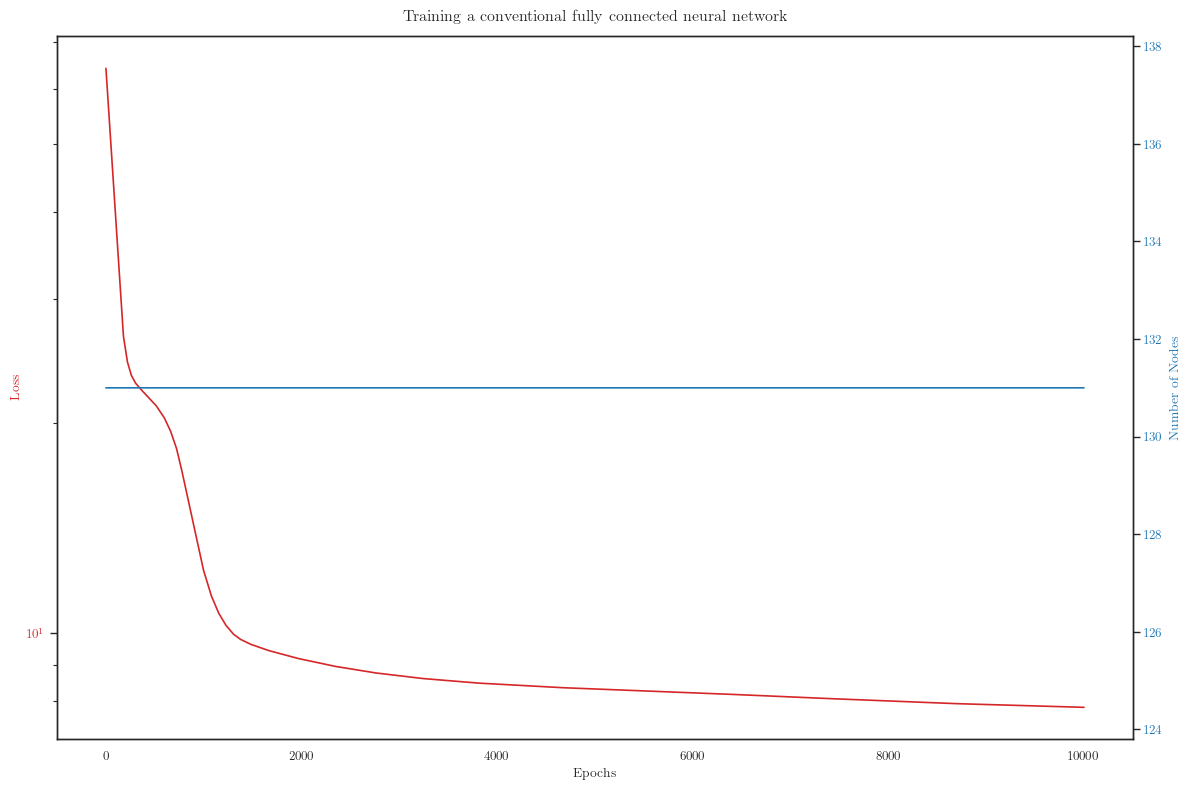

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))
num_epochs = len(loss_history)
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,num_epochs), loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,num_epochs), node_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Training a conventional fully connected neural network")
fig.tight_layout()

In [ ]:
# Evaluate the trained model
def evaluate_mlp(model):
    x_test, y_test = generate_data(100)
    y_pred = jax.vmap(model)(x_test)
    return x_test, y_test, y_pred

In [ ]:
x_test, y_test, y_pred = evaluate_mlp(model)

In [ ]:
# Plot the results
def plot_results(x, y_true, y_pred):
    plt.axes().set_aspect('equal')
    plt.plot(x, y_true, "." ,label='True sin(x)')
    plt.plot(x, y_pred, "." ,label='Predicted sin(x)')
    
    plt.legend()
    plt.show()

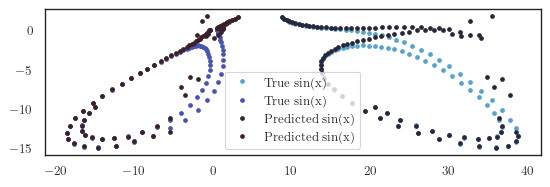

In [ ]:
plot_results(x_test, y_test, y_pred)